In [3]:
import os
from pathlib import Path
import yaml
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
def get_project_root():
    # Assuming a known file (e.g., 'main.py') exists in the project root
    # Adjust this to a file that reliably exists at your project root
    current_file_path = Path("../data/processed/data.yml").resolve() 
    
    # Traverse upwards until a known project root indicator is found
    # For example, searching for a '.git' directory
    for parent in current_file_path.parents:
        if (parent / ".git").exists():
            return parent
    
    # Fallback or error handling if root cannot be found
    return current_file_path.parent # Or raise an error

project_root = get_project_root()
print(f"Project Root: {project_root}")

Project Root: /Users/jennarong/Repos/Driver-drowsiness-detection


In [5]:
# โหลด config จาก data.yml
with open(project_root / "data/processed/data.yaml", "r") as f:
    data_cfg = yaml.safe_load(f)

train_dir = project_root / "data/processed/" / data_cfg["train"]
val_dir = project_root / "data/processed/" / data_cfg["val"]
test_dir = project_root / "data/processed/" / data_cfg["test"]
class_names = data_cfg.get("names", None)  # optional
num_classes = data_cfg.get("nc", None)

print(f"train path: {train_dir}");
print(f"val path: {val_dir}");
print(f"test path: {test_dir}");
print(f"class_names: {class_names}");
print(f"num_classes: {num_classes}");

train path: /Users/jennarong/Repos/Driver-drowsiness-detection/data/processed/train/images
val path: /Users/jennarong/Repos/Driver-drowsiness-detection/data/processed/valid/images
test path: /Users/jennarong/Repos/Driver-drowsiness-detection/data/processed/test/images
class_names: ['Microsleep', 'Nosleepiness', 'yawn']
num_classes: 3


In [6]:
IMG_SIZE = (224, 224)

def load_dataset(images_dir, labels_dir, num_classes):
    image_paths, labels = [], []

    for fname in os.listdir(images_dir):
        if fname.endswith(".jpg") or fname.endswith(".png"):
            img_path = os.path.join(images_dir, fname)
            label_path = os.path.join(labels_dir, fname.replace(".jpg", ".txt").replace(".png", ".txt"))
            if os.path.exists(label_path):
                with open(label_path, "r") as f:
                    readline = f.readline()
                    if readline.strip() == "":
                        class_id = 0   # default
                    else:
                        readline = readline.split(" ")
                        # print(f"{label_path} {readline}")
                        class_id = int(readline[0])  # just take the class id
                    
                image_paths.append(img_path)
                labels.append(class_id)

    ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    def process(img_path, label):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        return img, tf.one_hot(label, num_classes)

    return ds.map(process).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

In [7]:
NUM_CLASSES = num_classes   # 🔧 change to your actual number of classes
train_ds = load_dataset(train_dir, project_root / "data/processed/train/labels", NUM_CLASSES)
val_ds   = load_dataset(val_dir, project_root / "data/processed/valid/labels", NUM_CLASSES)

In [8]:
# โหลด VGG16 (ไม่เอา layer ข้างบน)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [9]:
# Freeze บางเลเยอร์ (เพื่อใช้ feature extractor เดิม)
for layer in base_model.layers:
    layer.trainable = False

In [10]:
# เพิ่มเลเยอร์ด้านบน (custom classifier)
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [11]:
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
# Compile โมเดล
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,243 (80.64 MB)

 Trainable params: 6,423,555 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1727s 4s/step - accuracy: 0.6554 - loss: 0.7711 - val_accuracy: 0.8270 - val_loss: 0.4320
Epoch 2/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1966s 5s/step - accuracy: 0.7595 - loss: 0.5446 - val_accuracy: 0.8657 - val_loss: 0.3604
Epoch 3/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 2226s 6s/step - accuracy: 0.7800 - loss: 0.4947 - val_accuracy: 0.8724 - val_loss: 0.3355
Epoch 4/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1979s 5s/step - accuracy: 0.8028 - loss: 0.4543 - val_accuracy: 0.8673 - val_loss: 0.3306
Epoch 5/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1926s 5s/step - accuracy: 0.8129 - loss: 0.4323 - val_accuracy: 0.8816 - val_loss: 0.3000
Epoch 6/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1923s 5s/step - accuracy: 0.8279 - loss: 0.4020 - val_accuracy: 0.8833 - val_loss: 0.3012
Epoch 7/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1942s 5s/step - accuracy: 0.8287 - loss: 0.4105 - val_accuracy: 0.8959 - val_loss: 0.2937
Epoch 8/10
392/392 ━━━━━━━━━━━━━━━━━━━━ 1734s 4s/step - accuracy: 0.8432 - loss: 0.3757 - 

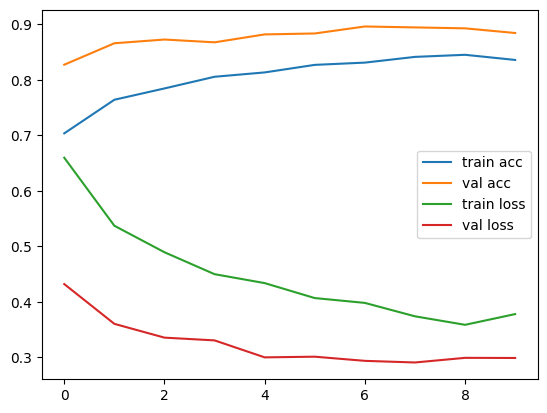

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [16]:
test_ds   = load_dataset(test_dir, project_root / "data/processed/test/labels", NUM_CLASSES)
loss, acc = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {acc:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 75s 4s/step - accuracy: 0.8737 - loss: 0.3276
Test Loss: 0.3248
Test Accuracy: 0.8685


In [19]:
import numpy as np

# Collect true labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

2025-09-25 01:27:39.157888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [20]:
cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=NUM_CLASSES)
print(cm.numpy())

[[101  51  11]
 [  5 234   7]
 [  1   3 180]]


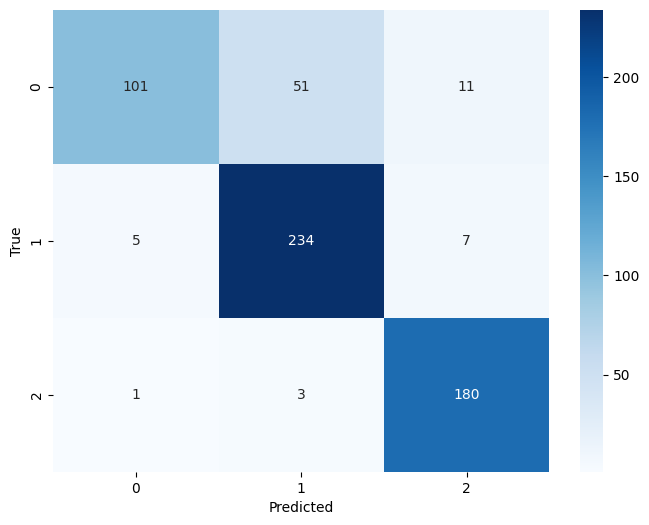

In [21]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(cm.numpy(), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [15]:
# model.save("vgg16_classifier.h5")